# 09wk-1: `with`의 사용

최규빈  
2024-11-01

<a href="https://colab.research.google.com/github/guebin/MP2024/blob/main/posts/09wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-ygh1QxRxgUXAxHCj33OPfP&si=8rIS7XDy6_f8vXkK>

# 2. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
#---#
import torch
import transformers
import tarfile

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

# 3. `with`

## A. 기본사용

`-` 아래와 같이 with를 사용한다. 여기에서 `????` 자리에 올 수 있는
오브젝트는 `__enter__` 와 `__exit__`을 포함하는 어떠한 오브젝트이다.
(그리고 이러한 오브젝트를 “컨텍스트 매니저”라고 부른다)

``` python
with ????:
    블라블라~
    야디야디~
```

`# 예제1` – 기본예제

`-` context manager 를 찍어내는 Dummy 클래스

In [2]:
class Dummy: 
    def __enter__(self):
        print("enter")
    def __exit__(self,*args): # *args는 에러처리 관련된 __exit__의 입력변수들 
        print("exit") 

In [3]:
d = Dummy()
d.__enter__()
print("context")
d.__exit__()

enter
context
exit

In [4]:
d = Dummy()
with d:
    print("context")

enter
context
exit

`-` `with` 뒤에 올 수 있는 오브젝트는 `__enter__` 와 `__exit__` 을
포함해야한다.

In [5]:
lst = [1,2,3]
with lst:
    pass 

In [6]:
with 33:
    pass 

`# 예제2` – 타이머

*원래 사용패턴*

In [8]:
t1 = time.time()
np.random.randn(100,100) + 30
t2 = time.time()
t2-t1

In [9]:
t1 = time.time()
np.random.randn(10000,10000) + 30
t2 = time.time()
t2-t1

In [24]:
class Timer:
    def __enter__(self):
        self.t1 = time.time()
    def __exit__(self,*args):
        self.t2 = time.time()
        print(f"{self.t2 - self.t1:.4f} 초 걸림")

In [26]:
with Timer():
    np.random.randn(10000,10000) + 30

1.4989 초 걸림

`#`

`# 예제3`

In [43]:
class 미분꼬리표추적금지:
    def __enter__(self):
        torch.set_grad_enabled(False)
    def __exit__(self,*args):
        torch.set_grad_enabled(True)

In [44]:
a = torch.tensor(1.0,requires_grad = True)
a

In [51]:
b = a+1 
c = 2*b 
d = c/3
b,c,d

In [52]:
with 미분꼬리표추적금지():
    b = a+1 
    c = 2*b 
    d = c/3
b,c,d

`#`

`# 예제4`

아래의 코드를 모델을 활용하여 로짓을 계산하라.

In [53]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2
)
model_input = {
    'input_ids': torch.tensor([[101, 2023, 3185, 2003, 6659, 2021, 2009, 2038, 2070, 2204, 3896, 1012, 102]]),
    'attention_mask': torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
    'labels': torch.tensor([0])
}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [60]:
logits = model(**model_input).logits
logits

`(풀이)`

In [61]:
with 미분꼬리표추적금지():
    logits = model(**model_input).logits
    print(logits)

tensor([[0.0505, 0.1006]])

`(풀이2)`

In [62]:
with torch.no_grad():
    logits = model(**model_input).logits
    print(logits)

tensor([[0.0505, 0.1006]])

ref:
<https://huggingface.co/docs/transformers/tasks/sequence_classification>

`#`

## B. 약간고급사용

`# 예비학습`

`-` 기본플랏

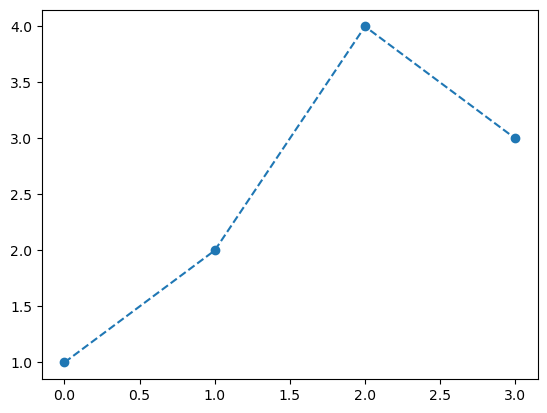

In [72]:
plt.plot([1,2,4,3],'--o')

`-` 크기를 (10,3)으로 조정

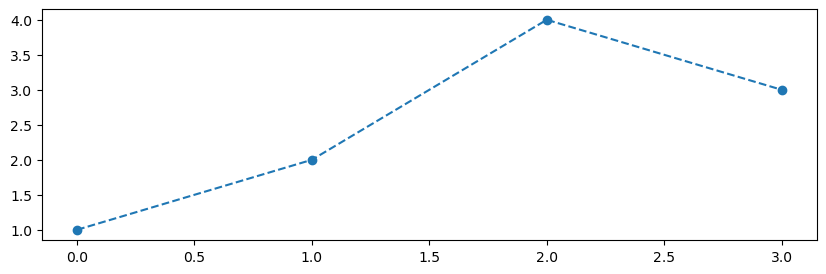

In [76]:
plt.rcParams['figure.figsize'] = [10, 3] 
plt.plot([1,2,4,3],'--o')

`-` 한번 뒤틀린 설정이 그대로 있음

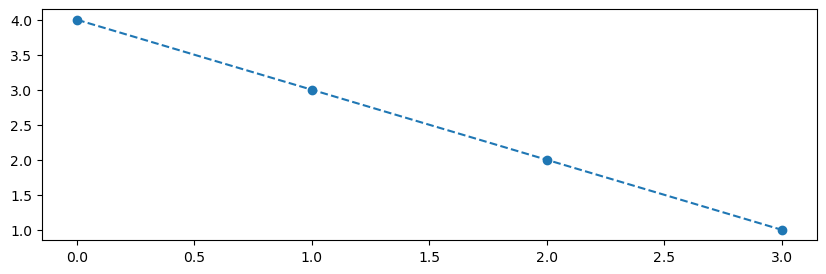

In [77]:
plt.plot([4,3,2,1],'--o')

`-` 설정을 원래대로

In [78]:
plt.rcdefaults()

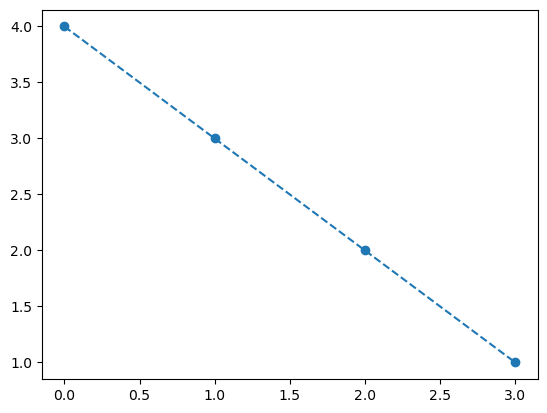

In [79]:
plt.plot([4,3,2,1],'--o')

`#`

`# 예제4` – 크기조정

In [88]:
class FigureSizeContext:
    def __enter__(self):
        def resize(w,h):
            plt.rcParams['figure.figsize'] = [w, h] 
        return resize
    def __exit__(self,*args):
        plt.rcdefaults()

`-` 사용예시1

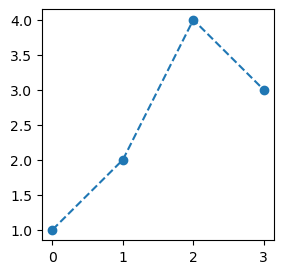

In [92]:
context_manager = FigureSizeContext()
xxxx = context_manager.__enter__()
xxxx(3,3)
plt.plot([1,2,4,3],'--o')
context_manager.__exit__()

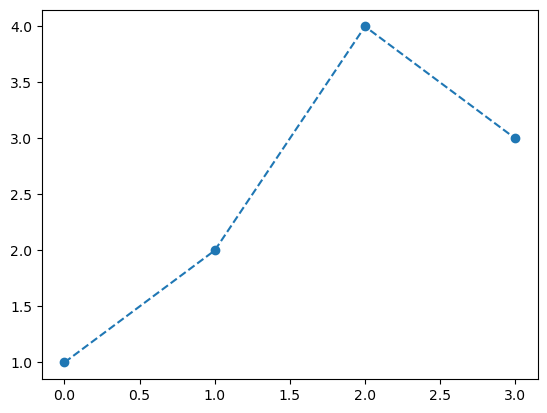

In [93]:
plt.plot([1,2,4,3],'--o')

`-` 사용예시2

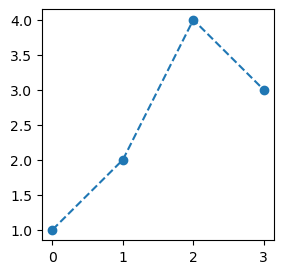

In [94]:
with FigureSizeContext() as xxxx:
    xxxx(3,3)
    plt.plot([1,2,4,3],'--o')

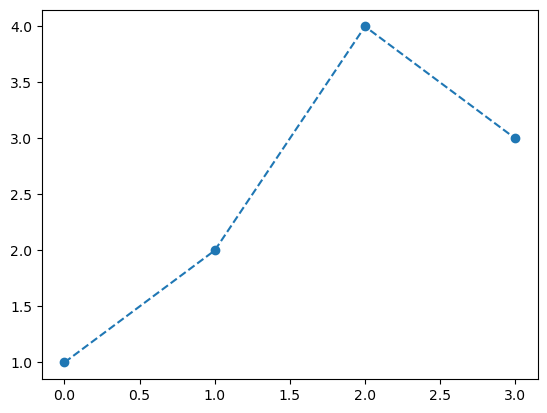

In [95]:
plt.plot([1,2,4,3],'--o')

`-` 정리하면.. `with`는 아래와 같이 `as`와 함께 사용가능한데,

``` python
with context_manager as xxxx: 
    블라블라~
    야디야디~
```

여기에서 `as`뒤의 xxxx 자리는 `context_manager.__enter__`의 리턴값이
차지하게 된다.

`#`

`# 예제5` – 샌드위치생성기

In [128]:
class 샌드위치생성기:
    def __init__(self,빵="기본빵"):
        self.빵 = 빵
        self.재료들 = []
    def __enter__(self):
        print(f"---{self.빵}---")
        return self
    def __exit__(self,*args):
        print(f"---{self.빵}---")
    def 재료추가하기(self,재료):
        print(재료)
        self.재료들.append(재료)

`-` 사용예시1

In [125]:
with 샌드위치생성기(빵="허니오트") as 샌드위치:
    샌드위치.재료추가하기("양상추")
    샌드위치.재료추가하기("치즈")
    샌드위치.재료추가하기("베이컨")
    샌드위치.재료추가하기("오이")

---허니오트---
양상추
치즈
베이컨
오이
---허니오트---

In [127]:
샌드위치.빵, 샌드위치.재료들

`-` 사용예시2

In [129]:
with 샌드위치생성기(빵="허니오트") as 샌드위치:
    샌드위치.재료추가하기("토마토")
    샌드위치.재료추가하기("치즈")
    샌드위치.재료추가하기("베이컨")
    샌드위치.재료추가하기("에그마요")

---허니오트---
토마토
치즈
베이컨
에그마요
---허니오트---

In [130]:
샌드위치.빵, 샌드위치.재료들

`-` 아래의 두 코드가 같은 효과를 가진다.

``` python
with 샌드위치생성기(빵="허니오트") as 샌드위치:
    샌드위치.재료추가하기("토마토")
    샌드위치.재료추가하기("치즈")
    샌드위치.재료추가하기("베이컨")
    샌드위치.재료추가하기("에그마요")
```

``` python
샌드위치 = 샌드위치생성기(빵="허니오트")
샌드위치 = 샌드위치.__enter__()
샌드위치.재료추가하기("토마토")
샌드위치.재료추가하기("치즈")
샌드위치.재료추가하기("베이컨")
샌드위치.재료추가하기("에그마요")
샌드위치.__exit__()
```

`-` 따라서 `__enter__` 가 `self`를 리턴하는 경우에는
`with 샌드위치생성기(빵="허니오트") as 샌드위치` 이 부분을 해석할때
“`샌드위치생성기(빵="허니오트")` 코드의 실행결과 만들어지는 오브젝트를
`샌드위치`로 저장”한다고 해석해도 무리가 없다.

`#`

`# 예제6`

`-` `example.txt` 를 만들고 “asdf” 라는 글자를 넣는 파이썬코드

In [136]:
with open("example.txt","w") as file: 
    # 대충해석: open("example.txt","w") 을 실행하여 나오는 오브젝트를 file로 받음 
    # 더 엄밀한 해석: 
    # open("example.txt","w") 을 실행하여 나오는 오브젝트를 ???라고 하자. 
    # 그런데 ??? 에는 `__enter__`가 있을텐데, 그 `__enter__`를 실행하여 나오는 오브젝트를 
    # file로 받음.
    file.write("asdf")    

`-` 분석하기: “대충해석”으로 해석해도 되는지 체크

In [137]:
file

In [138]:
context_manager = open("example.txt","w")
file = context_manager.__enter__()

In [139]:
type(context_manager), type(file)

`-` 분석하기2: `__enter__` 가 `self`를 리턴하는지 보자

In [142]:
context_manager.__enter__??
# 코드를 볼 수 없음... -- 아쉬움..

`#`

`# 예제7`

`-` `example.txt` 파일을 `example.tar.gz`로 압축하는 코드

In [145]:
with tarfile.open("example.tar.gz","w:gz") as tar:
    tar.add("example.txt", arcname="example.txt")

`-` 분석하기

In [147]:
context_manager = tarfile.open("example.tar.gz","w:gz")
tar = context_manager.__enter__()
type(context_manager), type(tar)

-   `context_manager.__enter__()` 는 `self`를 리턴하는듯함

`-` 분석하기2: `__enter__` 가 `self`를 리턴하는지 보자

In [148]:
tar.__enter__??

`#`